# **Libraries & Constants**

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Conv2D, MaxPool2D, Embedding, Reshape, Flatten, LSTM, GRU, SimpleRNN, Concatenate, concatenate, RepeatVector, TimeDistributed, Bidirectional
# from keras.layers.merge import concatenate
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences #from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)
import seaborn as sb
from scipy import sparse
from scipy.sparse import csr_matrix
import os
import string
from google.colab import drive
import json
import pickle

from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.porter import PorterStemmer
import spacy
import nltk
nltk.download('stopwords')
import re
# from transformers import AutoTokenizer,BertTokenizer,TFBertModel

import copy

# **Load Dataset and declare paths**

In [ ]:
drive.mount('/content/drive')
basePath = '/content/drive/MyDrive/AI Projects/Sentiment-Analysis/'
dataPath = basePath + 'amazon_reviews_us_Watches_v1_00.csv'

# **Preprocessing**

## **Tokenization, Stemming, Removing Stop words and Punctuation**

In [ ]:
dataset = pd.read_csv(dataPath)

<ipython-input-4-5118f10c515a>:1: DtypeWarning: Columns (17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(dataPath)


In [ ]:
useless_features = ['review_date', 'verified_purchase'] + list(dataset.columns[8:11]) + list(dataset.columns[0:7]) + list(dataset.columns[-7:])
print(useless_features)

dataset.drop(columns=useless_features, inplace=True)
# delete rows with nan elements
dataset = dataset.dropna()

['review_date', 'verified_purchase', 'helpful_votes', 'total_votes', 'vine', 'marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21']


In [ ]:
review_headline = np.array(dataset['review_headline'])
review_body = np.array(dataset['review_body'])
star_rating = np.array(dataset['star_rating'])
rev_class = np.empty_like(star_rating)

for i  in range(len(rev_class)):
  if star_rating[i] >= 4:
    rev_class[i] = 1  # class1 : Pos Class
  elif star_rating[i] <= 2:
    rev_class[i] = 2  # class2 : Neg class
  elif star_rating[i] == 3:
    rev_class[i] = 3  # class3 : Neutral class

dataset['rev_class'] = rev_class

dataset.head()

,star_rating,review_headline,review_body,rev_class
0,5,Five Stars,Absolutely love this watch! Get compliments al...,1
1,5,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,1
2,2,Two Stars,Scratches,2
3,5,Five Stars,"It works well on me. However, I found cheaper ...",1
4,4,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,1


In [ ]:
rev_class.shape

(960082,)

In [ ]:
pos_indices = np.where(rev_class == 1)[0]
neg_indices = np.where(rev_class == 2)[0]
neut_indice = np.where(rev_class == 3)[0]

np.random.seed(5)
pos_indices = np.random.choice(pos_indices, size=3300, replace=False)
neg_indices = np.random.choice(neg_indices, size=3300, replace=False)
neut_indices = np.random.choice(neut_indice, size=3400, replace=False)

sample_indices = np.concatenate([pos_indices, neg_indices, neut_indices], axis=0)
sample_indices

array([704698, 659317,  69078, ..., 242400, 285939, 890903])

In [ ]:
review_headline_sample = np.take(review_headline, sample_indices)
review_body_sample = np.take(review_body, sample_indices)
rev_class_sample = np.take(rev_class, sample_indices)

np.save(basePath + 'review_class.npy', rev_class)

rev_class_sample.shape, review_body_sample.shape, review_headline_sample.shape

((10000,), (10000,), (10000,))

In [ ]:
def w_tokenizer(text):
  tokenizer = WhitespaceTokenizer()
  tokenized_list = tokenizer.tokenize(text)
  return tokenized_list

def stemmer_porter(text_list):
  porter = PorterStemmer()
  return_list = []
  for i in range(len(text_list)):
      return_list.append(porter.stem(text_list[i]))
  return(return_list)


def remove_stopwords(text_list):
  NLTK_stopwords = nltk.corpus.stopwords.words('english')
  return_list = []
  for i in range(len(text_list)):
      if text_list[i] not in NLTK_stopwords:
          return_list.append(text_list[i])
  return return_list

def remove_punc(text):
    if isinstance((text), (str)):
        text = re.sub('<[^>]*>', '', text)
        text = re.sub('[\W]+', '', text.lower())
        return text
    if isinstance((text), (list)):
        return_list = []
        for i in range(len(text)):
            temp_text = re.sub('<[^>]*>', '', text[i])
            temp_text = re.sub('[\W]+', '', temp_text.lower())
            temp_text = re.sub('[0-9][0-9]+', '', temp_text.lower())
            temp_text = re.sub('\bbr\b', '', temp_text.lower())
            return_list.append(temp_text)
        return(return_list)
    else:
        pass

def preprocess_sentence(sentence):
  return remove_stopwords(stemmer_porter(remove_punc(w_tokenizer(sentence))))

In [ ]:
with tf.device('/GPU:0'):
  preprocessed_review_headline = [preprocess_sentence(x) for x in review_headline]
  preprocessed_review_body = [preprocess_sentence(x) for x in review_body]

preprocessed_review_headline_length = len(preprocessed_review_headline)
preprocessed_review_body_length = len(preprocessed_review_body)

In [ ]:
print(review_headline[484344])
print(preprocess_sentence(review_headline[484344]))

送人用的，希望会喜欢。To send people, hope you like
['送人用的希望会喜欢to', 'send', 'peopl', 'hope', 'like']


In [ ]:
# Tfidf Vectorizer (convert tokens to vector)
def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, analyzer='word', stop_words=None, lowercase=False, max_features=10000) #, token_pattern='(\d{0,2}[a-zA-Z]+\d{0,2}[a-zA-Z]*$)'
review_vector = vectorizer.fit_transform(preprocessed_review_headline + preprocessed_review_body)

sparse.save_npz(basePath + "review_vector_csr_matrix.npz", review_vector)

review_headline_vector = review_vector[:preprocessed_review_headline_length]
review_body_vector = review_vector[preprocessed_review_headline_length:]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
tfidf_features = vectorizer.get_feature_names_out()
print('number of features in tfidf: ', len(tfidf_features))

number of features in tfidf:  10000


In [ ]:
print('review_headline_vector shape: ', review_headline_vector.shape)
print('review_body_vector shape: ', review_body_vector.shape)

review_headline_vector shape:  (960082, 10000)
review_body_vector shape:  (960082, 10000)


In [ ]:
preprocessed_review_headline[:5]

[['five', 'star'],
 ['love', 'thiswatch', 'keep', 'time', 'wonder'],
 ['two', 'star'],
 ['five', 'star'],
 ['beauti', 'face', 'cheap', 'sound', 'link']]

In [ ]:
print(review_headline_vector[0])

  (0, 8168)	0.658577715594982
  (0, 3300)	0.7525127191760248


## **Load Preprocessed Dataset**

In [33]:
review_vector = sparse.load_npz(basePath + "review_vector_csr_matrix.npz")

preprocessed_review_headline_length = review_vector.shape[0]//2
review_headline_vector = review_vector[:preprocessed_review_headline_length]
review_body_vector = review_vector[preprocessed_review_headline_length:]
review_class = np.load(basePath + 'review_class.npy')

review_headline_vector.shape, review_body_vector.shape, review_class.shape

((960082, 10000), (960082, 10000), (960082,))

**Splitting Dataset**

In [34]:
headline_train, headline_test, body_train, body_test, y_train, y_test = train_test_split(review_headline_vector, review_body_vector, review_class, test_size=0.40, random_state=75)
headline_dev, headline_test, body_dev, body_test, y_dev, y_test = train_test_split(headline_test, body_test, y_test, test_size=0.50, random_state=75)

print('train shape: ', headline_train.shape, body_train.shape, y_train.shape)
print('dev shape: ', headline_dev.shape, body_dev.shape, y_dev.shape)
print('test shape: ', headline_test.shape, body_test.shape, y_test.shape)

train shape:  (576049, 10000) (576049, 10000) (576049,)
dev shape:  (192016, 10000) (192016, 10000) (192016,)
test shape:  (192017, 10000) (192017, 10000) (192017,)


In [35]:
print(headline_train[6])

  (0, 3931)	0.7233393429998286
  (0, 1646)	0.5429914847679976
  (0, 4998)	0.4265447717860598


In [36]:
# sort sparse matrix
csr_matrix.sort_indices(headline_train)
csr_matrix.sort_indices(headline_dev)
csr_matrix.sort_indices(headline_test)
csr_matrix.sort_indices(body_train)
csr_matrix.sort_indices(body_dev)
csr_matrix.sort_indices(body_test)

In [37]:
print(headline_train[6])

  (0, 1646)	0.5429914847679976
  (0, 3931)	0.7233393429998286
  (0, 4998)	0.4265447717860598


# **Models**

## **Naive Bayez**

In [38]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# horizontal stacking
X_train = sparse.hstack((body_train, headline_train))
X_test = sparse.hstack((body_test, headline_test))

# Build a Gaussian Classifier
model = MultinomialNB(force_alpha=True)

# Model training
model.fit(X_train, y_train)

# Predict Output
print(X_test[6].shape)
predicted = model.predict(X_test[6])

print("Actual Value:", y_test[6])
print("Predicted Value:", predicted[0])

(1, 20000)
Actual Value: 2
Predicted Value: 2


Accuracy: 0.8815573621085633


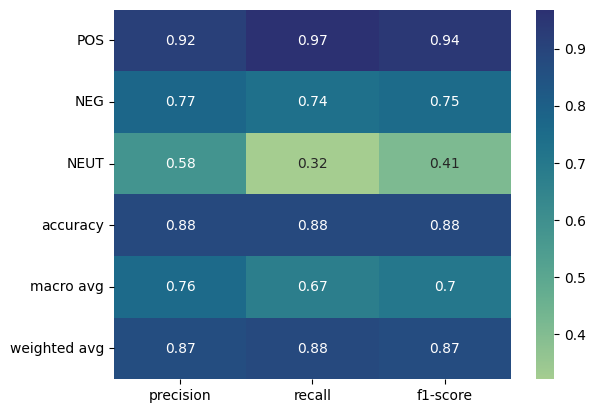

In [39]:
y_pred = model.predict(X_test)
accuray = accuracy_score(y_pred, y_test)

report = classification_report(y_test, y_pred, target_names=['POS', 'NEG', 'NEUT'], output_dict=True)
sb.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='crest')

print("Accuracy:", accuray)

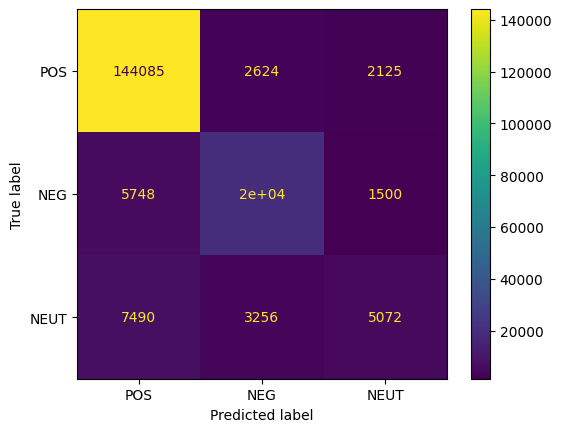

In [40]:
labels = [1,2,3]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['POS', 'NEG', 'NEUT'])
disp.plot();

## **Neural Network**

In [10]:
X_train = [headline_train, body_train]
X_dev = [headline_dev, body_dev]
X_test = [headline_test, body_test]


y_train_OH = to_categorical(y_train)[:, 1:4]
y_dev_OH = to_categorical(y_dev)[:, 1:4]
y_test_OH = to_categorical(y_test)[:, 1:4]

validation_data = (X_dev, y_dev_OH)
y_train_OH.shape

(576049, 3)

In [25]:
def showPlots(history):
  plt.plot(history['accuracy'],
            label='training accuracy', marker='.', color='green')
  plt.plot(history['val_accuracy'],
            label='test accuracy', marker='.', color='blue')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(history['loss'],
            label='training loss', marker='.', color='green')
  plt.plot(history['val_loss'],
            label='test loss', marker='.', color='blue')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# function for convert probablity to 0s and 1s for multiple classification
def argmaxKeepDimensions(arr):
  tmp = np.zeros_like(arr)
  tmp[np.arange(len(arr)), arr.argmax(1)] = 1
  return tmp

In [16]:
# Functional Model
input1 = Input(shape=X_train[0].shape[1:], sparse=True)
input2 = Input(shape=X_train[1].shape[1:], sparse=True)

d1 = Dense(128, activation='relu')(input1)
d1 = Dropout(0.2)(d1)
d1 = BatchNormalization()(d1)

d2 = Dense(128, activation='relu')(input2)
d2 = Dropout(0.2)(d2)
d2 = BatchNormalization()(d2)

c = Concatenate()([d1, d2])

d = Dense(64, activation='relu')(c)
d = Dropout(0.2)(d)
d = BatchNormalization()(d)

output = Dense(3, activation="softmax")(d)

# Compile the Model
model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

Epoch 1/10
1126/1126 [==============================] - 133s 113ms/step - loss: 0.3180 - accuracy: 0.8845 - val_loss: 0.2700 - val_accuracy: 0.8973
Epoch 2/10
1126/1126 [==============================] - 46s 39ms/step - loss: 0.2432 - accuracy: 0.9077 - val_loss: 0.2580 - val_accuracy: 0.9027
Epoch 3/10
1126/1126 [==============================] - 37s 30ms/step - loss: 0.2118 - accuracy: 0.9187 - val_loss: 0.2658 - val_accuracy: 0.9018
Epoch 4/10
1126/1126 [==============================] - 31s 26ms/step - loss: 0.1799 - accuracy: 0.9313 - val_loss: 0.2849 - val_accuracy: 0.8991
Epoch 5/10
1126/1126 [==============================] - 30s 25ms/step - loss: 0.1515 - accuracy: 0.9423 - val_loss: 0.3148 - val_accuracy: 0.8962
Epoch 6/10
1126/1126 [==============================] - 28s 24ms/step - loss: 0.1284 - accuracy: 0.9514 - val_loss: 0.3443 - val_accuracy: 0.8934
Epoch 7/10
1126/1126 [==============================] - 25s 21ms/step - loss: 0.1124 - accuracy: 0.9578 - val_loss: 0.3674

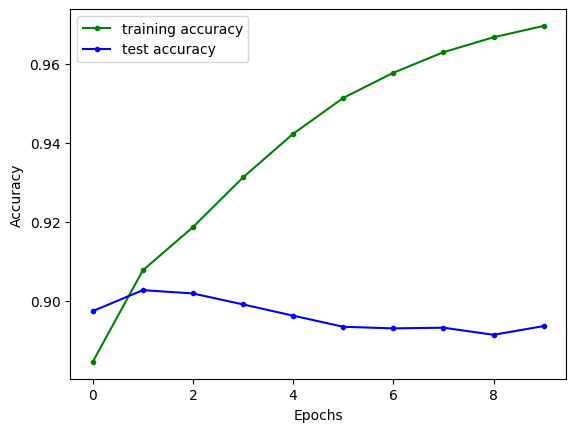

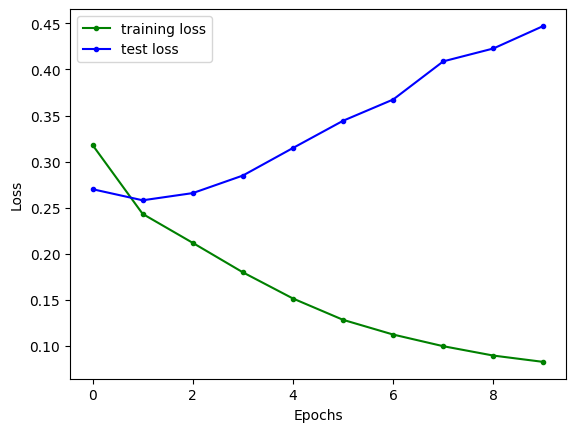

In [17]:
# train the model
filepath = basePath + 'NN_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train_OH, validation_data=validation_data, epochs=10, batch_size=512, verbose=1, callbacks=[checkpoint]).history

showPlots(history)

In [28]:
filepath = basePath + 'NN_model.hdf5'
model = load_model(filepath)
with tf.device('/GPU:0'):
  model.evaluate(X_test, y_test_OH, verbose=0)
  y_pred = model.predict(X_test)

6001/6001 [==============================] - 24s 4ms/step


Accuracy: 0.9030971216090242


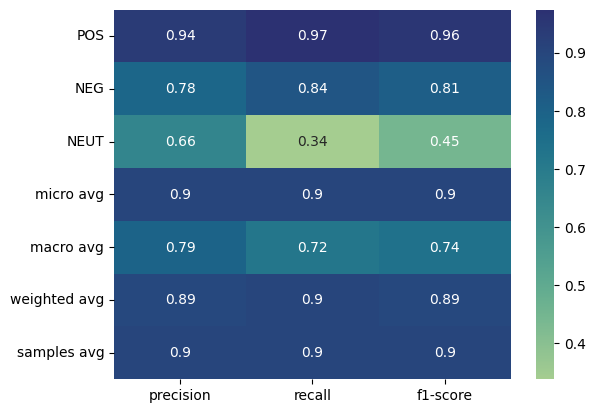

In [31]:
y_pred_OH = argmaxKeepDimensions(y_pred)
accuray = accuracy_score(y_pred_OH, y_test_OH)

report = classification_report(y_test_OH, y_pred_OH, target_names=['POS', 'NEG', 'NEUT'], output_dict=True)
sb.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='crest')

print("Accuracy:", accuray)

# **Helper**

In [ ]:
# delete samples which their body or headline is empty

def deleteSomeIndicesFromList(a, indices):
  a = a.copy()
  for index in sorted(indices, reverse=True):
    a.pop(index)
  return a

indices = [i for i, x in enumerate(review_body_encoded) if len(x)==0]
indices = indices + [i for i, x in enumerate(review_headline_encoded) if len(x)==0]
indices = np.unique(indices)

print('index of samples which their body or headline are empty: ', indices)

review_body_dropped = deleteSomeIndicesFromList(review_body_encoded, indices)
review_headline_dropped = deleteSomeIndicesFromList(review_headline_encoded, indices)
rev_class_dropped = deleteSomeIndicesFromList(rev_class, indices)

len(review_body_dropped), len(review_headline_dropped), len(rev_class_dropped)

index of samples which their body or headline are empty:  [  1514   1632   1830 ... 952604 955484 956398]


(958554, 958554, 958554)